# QEI (Q-Noisy Expected Improvement) Demo for Blog

In [1]:
import numpy as np
import qmcpy as qp
from scipy.linalg import solve_triangular, cho_solve, cho_factor
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

lw = 3
ms = 8

## Problem setup

Here is the current data ($x$ and $y$ values with noise) from which we want to build a GP and run a Bayesian optimization.

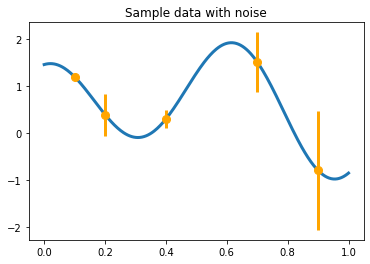

In [2]:
def yf(x):
    return np.cos(10 * x) * np.exp(.2 * x) + np.exp(-5 * (x - .4) ** 2)

xplt = np.linspace(0, 1, 300)
yplt = yf(xplt)

x = np.array([.1, .2, .4, .7, .9])
y = yf(x)
v = np.array([.001, .05, .01, .1, .4])

plt.plot(xplt, yplt, linewidth=lw)
plt.plot(x, y, 'o', markersize=ms, color='orange')
plt.errorbar(x, y, yerr=2 * np.sqrt(v), marker='', linestyle='', color='orange', linewidth=lw)
plt.title('Sample data with noise');

## Computation of the qEI quantity using `qmcpy`

One quantity which can appear often during BO is a computation involving $q$ "next points" to sample in a BO process; in the standard formulation this quantity might involve just $q=1$, but $q>1$ is also of interest for batched evaluation in parallel.

This quantity is defined as
$$
\mathrm{EI}_q(x_1, \ldots, x_q;\mathbf{y}, \mathcal{X}, \boldsymbol{\epsilon}) = \int_{\mathbb{R}^q} \max_{1\leq i\leq q}\left[{(y_i - y^*)_+}\right]\, p_{Y_{x_1,\ldots, x_q}|\mathbf{y}, \mathcal{X}, \boldsymbol{\epsilon}}(y_1, \ldots, y_q)\; \text{d}y_1\cdots\text{d}y_q
$$

The example I am considering here is with $q=5$ but this quantity could be made larger.  Each of these QEI computations (done in a vectorized fashion in production) would be needed in an optimization loop (likely powered by CMAES or some other high dimensional nonconvex optimization tool).  This optimization problem would take place in a $qd$ dimensional space, which is one aspect which usually prevents $q$ from being too large.

Note that some of this will look much more confusing in $d>1$, but it is written here in a simplified version.

## GP model definition (kernel information) and qEI definition

In [3]:
shape_parameter = 4.1
process_variance = .9
fudge_factor = 1e-10

def gaussian_kernel(x, z):
    return process_variance * np.exp(-shape_parameter ** 2 * (x[:, None] - z[None, :]) ** 2)

def gp_posterior_draws(x_to_draw, mc_strat, num_posterior_draws):
    n = len(x_to_draw)
    
    kernel_prior_data = gaussian_kernel(x, x)
    kernel_cross_matrix = gaussian_kernel(x_to_draw, x)
    kernel_prior_plot = gaussian_kernel(x_to_draw, x_to_draw)
    prior_cholesky = np.linalg.cholesky(kernel_prior_data + np.diag(v))
    
    partial_cardinal_functions = solve_triangular(prior_cholesky, kernel_cross_matrix.T, lower=True)
    posterior_covariance = kernel_prior_plot - np.dot(partial_cardinal_functions.T, partial_cardinal_functions)
    posterior_cholesky = np.linalg.cholesky(posterior_covariance + fudge_factor * np.eye(n))
    
    full_cardinal_functions = solve_triangular(prior_cholesky.T, partial_cardinal_functions, lower=False)
    posterior_mean = np.dot(full_cardinal_functions.T, y)

    if mc_strat == 'numpy':
        normal_draws = np.random.normal(size=(num_posterior_draws, n))
    else:
        discrete_distribution = qp.IIDStdGaussian(n)
        if mc_strat == 'lattice':
            discrete_distribution = qp.Lattice(n)
        elif mc_strat == 'sobol':
            discrete_distribution = qp.Sobol(n)
        gaussian_distribution = qp.Gaussian(discrete_distribution)
        normal_draws = gaussian_distribution.gen_samples(num_posterior_draws)

    posterior_draws = posterior_mean[:, None] + np.dot(posterior_cholesky, normal_draws.T)
    return posterior_draws

In [4]:
def compute_qei(next_x, mc_strat, num_posterior_draws):
    q = len(next_x)
    
    kernel_prior_data = gaussian_kernel(x, x)
    kernel_cross_matrix = gaussian_kernel(next_x, x)
    kernel_prior_plot = gaussian_kernel(next_x, next_x)
    prior_cholesky = np.linalg.cholesky(kernel_prior_data + np.diag(v))
    
    partial_cardinal_functions = solve_triangular(prior_cholesky, kernel_cross_matrix.T, lower=True)
    posterior_covariance = kernel_prior_plot - np.dot(partial_cardinal_functions.T, partial_cardinal_functions)
    posterior_cholesky = np.linalg.cholesky(posterior_covariance + fudge_factor * np.eye(q))
    
    # Don't need cardinal functions ... would be faster solving against y
    full_cardinal_functions = solve_triangular(prior_cholesky.T, partial_cardinal_functions, lower=False)
    posterior_mean = np.dot(full_cardinal_functions.T, y)

    if mc_strat == 'numpy':
        normal_draws = np.random.normal(size=(num_posterior_draws, q))
    else:
        discrete_distribution = qp.IIDStdGaussian(q)
        if mc_strat == 'lattice':
            discrete_distribution = qp.Lattice(q)
        elif mc_strat == 'sobol':
            discrete_distribution = qp.Sobol(q)
        gaussian_distribution = qp.Gaussian(discrete_distribution)
        normal_draws = gaussian_distribution.gen_samples(num_posterior_draws)

    posterior_draws = posterior_mean[:, None] + np.dot(posterior_cholesky, normal_draws.T)
    return np.mean(np.fmax(np.max(posterior_draws[:, :num_posterior_draws] - max(y), axis=0), 0))

## Demonstrate the concept of qEI on 2 points

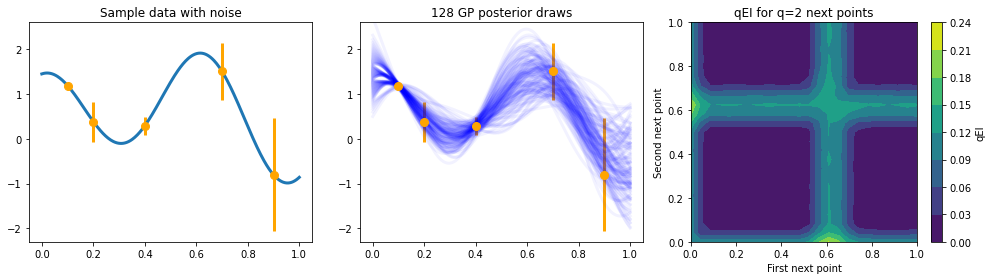

In [5]:
num_posterior_draws = 2 ** 7
Np = (25, 24)
X, Y = np.meshgrid(np.linspace(0, 1, Np[1]), np.linspace(0, 1, Np[0]))
xp = np.array([X.reshape(-1), Y.reshape(-1)]).T
y_draws = gp_posterior_draws(xplt, 'lattice', num_posterior_draws)

qei_vals = np.empty(len(xp))
for k, next_x in enumerate(xp):
    qei_vals[k] = compute_qei(next_x, 'sobol', num_posterior_draws)
Z = qei_vals.reshape(Np)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

ax = axes[0]
ax.plot(xplt, yplt, linewidth=lw)
ax.plot(x, y, 'o', markersize=ms, color='orange')
ax.errorbar(x, y, yerr=2 * np.sqrt(v), marker='', linestyle='', color='orange', linewidth=lw)
ax.set_title('Sample data with noise')
ax.set_ylim((-2.3, 2.6))

ax = axes[1]
ax.plot(xplt, y_draws, linewidth=lw, color='b', alpha=.05)
ax.plot(x, y, 'o', markersize=ms, color='orange')
ax.errorbar(x, y, yerr=2 * np.sqrt(v), marker='', linestyle='', color='orange', linewidth=lw)
ax.set_title(f'{num_posterior_draws} GP posterior draws')
ax.set_ylim((-2.3, 2.6))

ax = axes[2]
h = ax.contourf(X, Y, Z)
ax.set_xlabel('First next point')
ax.set_ylabel('Second next point')
ax.set_title('qEI for q=2 next points')
cax = fig.colorbar(h, ax=ax)
cax.set_label('qEI')

fig.tight_layout()
# plt.savefig('test_problem.png')

## Choose some set of next points against which to test the computation

Here, we consider $q=5$, which is much more costly to compute than the $q=2$ demonstration above.

**Note** This will take some time to run.  Use fewere `num_repeats` to reduce the cost.

In [6]:
num_posterior_draws_to_test = 2 ** np.arange(4, 20)
next_x = np.array([0.158,  0.416,  0.718,  0.935,  0.465])

vals = {}
num_repeats = 50
mc_strats = ('numpy', 'iid', 'lattice', 'sobol')
for mc_strat in mc_strats:
    vals[mc_strat] = []

    for num_posterior_draws in num_posterior_draws_to_test:
        all_estimates = []
        for _ in range(num_repeats):
            all_estimates.append(compute_qei(next_x, mc_strat, num_posterior_draws))
        vals[mc_strat].append(all_estimates)

    vals[mc_strat] = np.array(vals[mc_strat])
reference_answer = compute_qei(next_x, 'sobol', 2 ** 4 * max(num_posterior_draws_to_test))

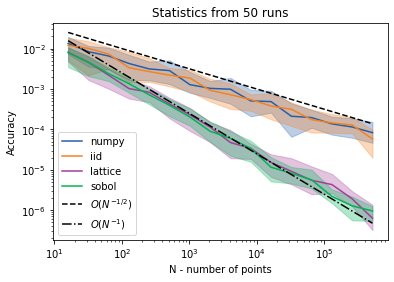

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

colors = ('#245EAB', '#F5811F', '#A23D97', '#00B253')
alpha = .3

for (name, results), color in zip(vals.items(), colors):
    bot = np.percentile(abs(results - reference_answer), 25, axis=1)
    med = np.percentile(abs(results - reference_answer), 50, axis=1)
    top = np.percentile(abs(results - reference_answer), 75, axis=1)
    ax.loglog(num_posterior_draws_to_test, med, label=name, color=color)
    ax.fill_between(num_posterior_draws_to_test, bot, top, color=color, alpha=alpha)
ax.loglog(num_posterior_draws_to_test, .1 * num_posterior_draws_to_test ** -.5, '--k', label='$O(N^{-1/2})$')
ax.loglog(num_posterior_draws_to_test, .25 * num_posterior_draws_to_test ** -1.0, '-.k', label='$O(N^{-1})$')
ax.set_xlabel('N - number of points')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower left')
ax.set_title(f'Statistics from {num_repeats} runs');

# plt.savefig('qei_convergence.png');